# Derivative with respect to flight parameters, multiple dimensions

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

try:
    import dolfin as dl
    using_firedrake = False
except ImportError:
    import firedrake as dl
    using_firedrake = True
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

tStart_notebook = time.time()

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Parameter class not available


## User settings

In [2]:
meshDim = 100
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 5
n_search = 30
n_test = 50

eval_mode = "point-eval" # because it's faster for testing code

dt = 0.001
final_time = 4

control = "speed"
#control = "radius"

## Setup

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000651917s, CPU 0.000725s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.189885s, CPU 0.173935s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.76248e-05s, CPU 1e-05s)
Info    : 10851 nodes 21716 elements
Info    : Writing 'houses.msh'...
Info    : Done writing 'houses.msh'


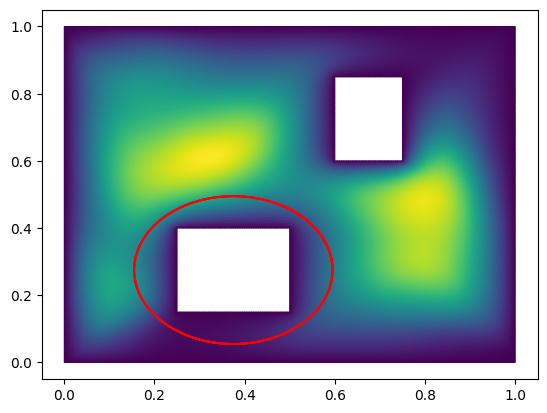

In [3]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
grid_t = np.arange(0, final_time+dt, dt)

para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_steadystate_true = fom.solve_steady(forcing=m)

# set default flying parameters
flying_parameters = {
                "radius" : 0.22,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.75 # 0.3
            }

drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)

prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))
noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01)
brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)

fom.plot(sol_steadystate_true, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

In [4]:
sol_steadystate = np.empty((n_para), dtype = object)

for i in range(n_para):
    m = fom.assemble_forcing(para=np.eye(n_para)[:, i])
    sol_steadystate[i] = fom.solve_steady(forcing=m)

## Derivative
For bettere distinction, I'll call the flight-parameterization the "control" from here onwards. Then the word "parameter" refers to the parameters of interest we are approximating in our inverse problem.

We should be able to copy most functions over from the 1D case without major changes. 

In [5]:
if control == "speed":
    control_test = 0.75
    vec_control = np.linspace(0.2, 1.4, n_test)
    
elif control == "radius":
    control_test = 0.2
    radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
    radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
    vec_control = np.linspace(radius_min, radius_max, n_test)
    
else:
    raise NotImplementedError("invalid control type {}".format(control))

### Derivative of the position

In [6]:
if control == "speed":
    
    def d_position_d_control(t, flying_parameters = flying_parameters):
    
        radius = flying_parameters["radius"]
        speed = flying_parameters["speed"]

        round_trip_time = 2 * np.pi * radius / speed
        angles = (t * 2 * np.pi) / round_trip_time
        pos = t * np.hstack([-np.sin(angles), np.cos(angles)]).T 

        return pos

elif control == "radius":
    
    def d_position_d_control(t, flying_parameters = flying_parameters):
    
        radius = flying_parameters["radius"]
        speed = flying_parameters["speed"]

        round_trip_time = 2 * np.pi * radius / speed
        angles = (t * 2 * np.pi) / round_trip_time
        pos = np.hstack([np.cos(angles), np.sin(angles)]).T 
        pos = pos - (t * speed) * np.hstack([-np.sin(angles), np.cos(angles)]).T / radius

        return pos
    
else:
    
    raise NotImplementedError("invalid control type {}".format(control))

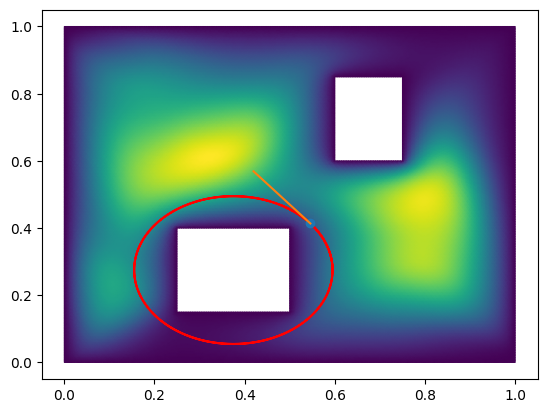

In [8]:
## test plot

# user setting
t = 0.2

# plot trajectory
fom.plot(sol_steadystate_true, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

# get derivative
k = np.argmin(np.abs(grid_t - t))
der = d_position_d_control(t = grid_t[k])

# plot derivative
plt.plot([pos[k, 0]], [pos[k, 1]], marker = "o")
plt.plot([pos[k, 0], pos[k, 0] + 1 * der[0]], [pos[k, 1], pos[k, 1] +1 * der[1]])

### derivative of the measurement

In [9]:
Du = [dl.grad(sol_steadystate[i]) for i in range(n_para)]
if using_firedrake:
    Du = [dl.project(Du[i], dl.VectorFunctionSpace(fom.mesh, 'P', 1)) for i in range(n_para)]
else:
    Du = [dl.project(Du[i]) for i in range(n_para)]

def d_measurement_d_control(t, flying_parameters = flying_parameters):
    
    position = drone.get_position(t=t, flying_parameters = flying_parameters)
    grad_p = d_position_d_control(t=t, flying_parameters = flying_parameters)
    
    Du_at_position = np.empty((2, n_para))
    
    if eval_mode == "point-eval":
        for i in range(n_para):
            Du_at_position[:, i] = Du[i](position)
    else:
        raise NotImplementedError("still need to do the maths for other measurement types")
        
    return Du_at_position.T @ grad_p

/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison fa

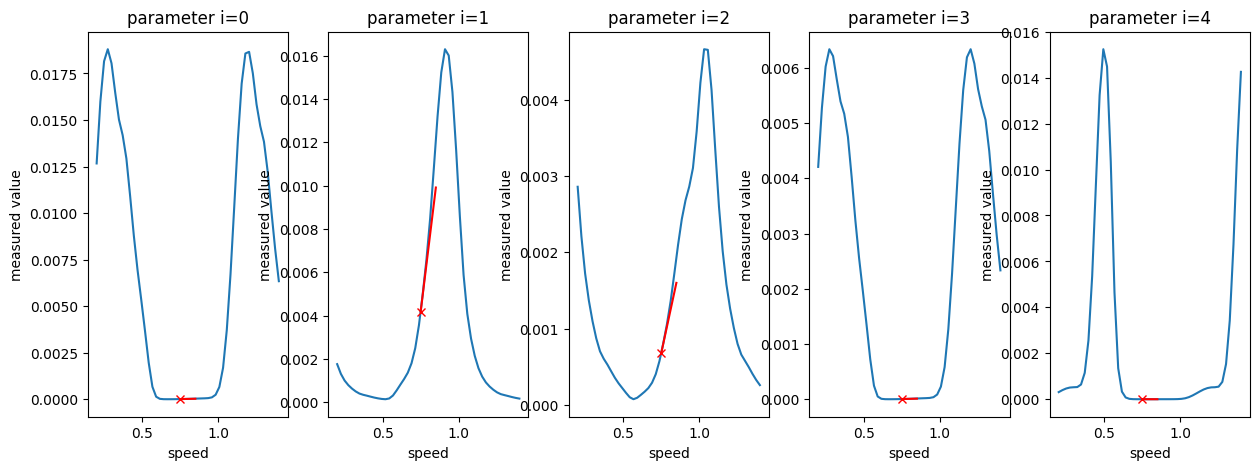

In [10]:
t = 1.5

pos_test = np.zeros((n_test, 2))
for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2[control] = vec_control[i]
    pos_test[i, :] = drone.get_position(t=t, flying_parameters=flying_parameters_2)
    
# dl.plot(sol_steadystate, mesh=fom.mesh)
# plt.plot(pos_test[:, 0], pos_test[:, 1], color="r")

measurements = [drone.measure(flightpath=pos_test, state=sol_steadystate[i]) for i in range(n_para)]
# note: this only works this way for steady-state - in the transient case we need to pass the state at time t

flying_parameters_2 = flying_parameters.copy()
flying_parameters_2[control] = control_test
d_test = d_measurement_d_control(t=t, flying_parameters=flying_parameters_2)
position = drone.get_position(t=t, flying_parameters=flying_parameters_2)
val = [drone.measure(flightpath = np.array([position]), state = sol_steadystate[i]) for i in range(n_para)]


fig, axs = plt.subplots(1,n_para, figsize = (15, 5))

for i in range(n_para):
    axs[i].plot(vec_control, measurements[i])
    axs[i].plot([control_test, control_test + 0.1], [val[i], val[i] + 0.1 * d_test[i]], color = "red")
    axs[i].plot([control_test], [val[i]], marker = "x", color = "red")

    axs[i].set_xlabel(control)
    axs[i].set_ylabel("measured value")
    axs[i].set_title("parameter i={}".format(i))

### derivative of the inverse posterior covariance matrix

In [11]:
def d_invPostCov_d_speed(flying_parameters=flying_parameters):
    
    drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
    pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)
    
    BU = np.empty((grid_t.shape[0], n_para))
    for i in range(n_para):
        BU[:, i] = drone.measure(flightpath = pos, state=sol_steadystate[i])
    
    dBU = np.zeros(BU.shape)
    for k in range(dBU.shape[0]):
        dBU[k] = d_measurement_d_control(t=grid_t[k], flying_parameters=flying_parameters)
        
    invCovBU = noise_model.apply_covar_inv(BU)
    
    return dBU.T @ invCovBU + invCovBU.T @ dBU

In [12]:
val_test = np.zeros((n_test,), dtype = object)

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2[control] = vec_control[i]

    drone_2 = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
    brain_2 = Brain(fom=fom, drone=drone_2, prior=prior, noise_model=noise_model)
    post_2 = brain_2.compute_posterior()
    val_test[i] = post_2.covar_inv

/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison fa

/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison fa

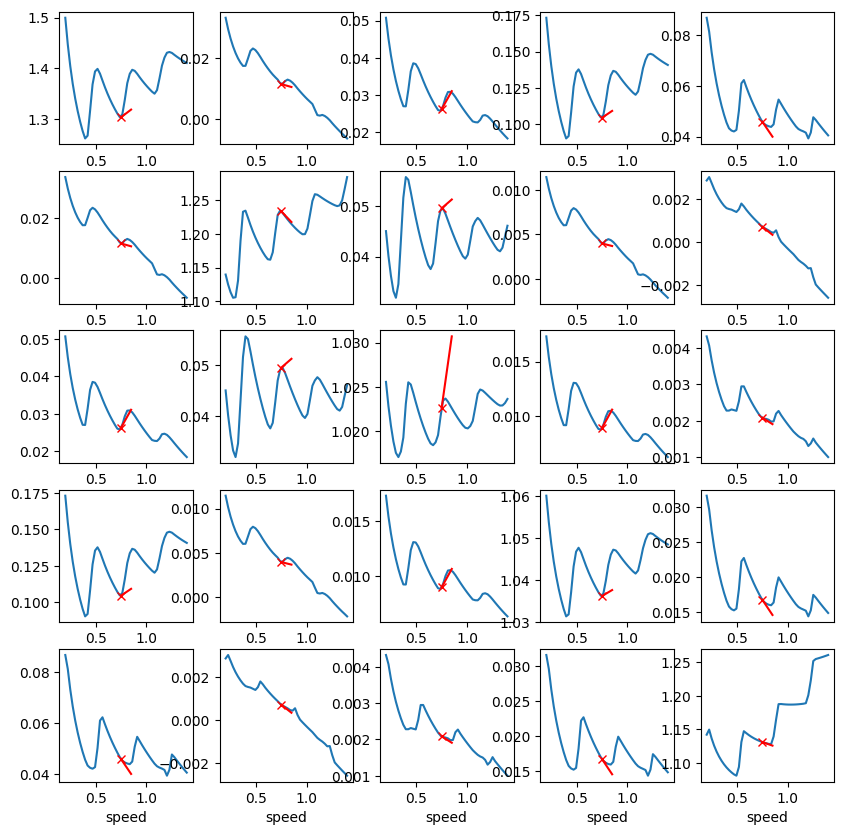

In [13]:
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2[control] = control_test

drone_2 = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
brain_2 = Brain(fom=fom, drone=drone_2, prior=prior, noise_model=noise_model)
post_2 = brain_2.compute_posterior()
val = post_2.covar_inv
d_val = d_invPostCov_d_speed(flying_parameters=flying_parameters_2)


fig, axs = plt.subplots(n_para, n_para, figsize = (10, 10))

for i in range(n_para):
    for j in range(n_para):
        
        axs[i,j].plot(vec_control, [val_test[k][i,j] for k in range(n_test)])
        axs[i,j].plot([control_test, control_test + 0.1], [val[i,j], val[i,j] + 0.1 * d_val[i,j]], color = "red")
        axs[i,j].plot([control_test], [val[i,j]], marker = "x", color = "red")

        axs[i,j].set_xlabel(control)
        #axs[i,j].set_ylabel("inverse posterior covariance, entry ({},{})".format(i,j))

### Derivative of the posterior covariance matrix

In [13]:
def d_PostCov_d_control(flying_parameters=flying_parameters, bool_return_both = True):
    
    drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
    pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)
    
    BU = np.empty((grid_t.shape[0], n_para))
    for i in range(n_para):
        BU[:, i] = drone.measure(flightpath = pos, state=sol_steadystate[i])
        
    invCovBU = noise_model.apply_covar_inv(BU)
    invPostCov = BU.T @ invCovBU + prior.covar_inv
    
    # sanity check, comment out for better performance
#     brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
#     post = brain.compute_posterior()
#     test = post.covar_inv
#     print("Sanity check:", np.isclose(invPostCov, test).all())
    
    # get derivative of inverse posterior covariance matrix
    yolo = d_invPostCov_d_speed(flying_parameters=flying_parameters)
    if len(yolo.shape) == 0:
        yolo = np.array(np.array([yolo]))
    # todo: the call to d_invPostCov_d_speed re-computes a lot of parts that are already computed here,
    #  i.e., it's redundant. I keep it here for easier debugging - if it turns out that there's an error above
    #  I won't need to change it in two places. When we put this into the source code we should optimize this call
    # out though
    
    PostCov = la.inv(invPostCov)
    derivative = -PostCov @ yolo @ PostCov
    # todo: I'm using la.inv here because I also want to return the matrix below. However, when we adapt this
    # into the source code we need to replace it with a proper linear system solve
    
    if bool_return_both:
        # todo: the return here of the posterior covariance is only for faster comparison in the plots below
        # in practice we should NOT compute it, especially not using la.inv
        return derivative, PostCov
    
    return derivative

In [14]:
val_test_2 = np.zeros((n_test,), dtype=object)
d_test_2 = np.zeros((n_test,), dtype=object)

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2[control] = vec_control[i]
    d_test_2[i], val_test_2[i] = d_PostCov_d_control(flying_parameters=flying_parameters_2)

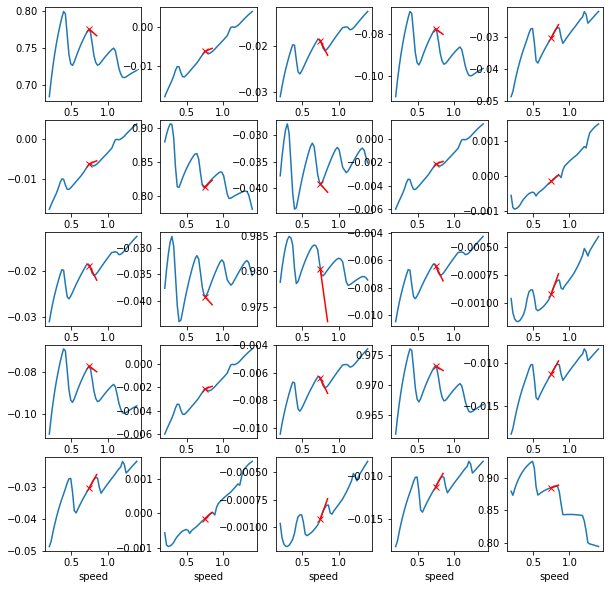

In [15]:
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2[control] = control_test
d_val, val = d_PostCov_d_control(flying_parameters=flying_parameters_2)
d_val = d_val
val = val

fig, axs = plt.subplots(n_para, n_para, figsize=(10, 10))

for i in range(n_para):
    for j in range(n_para):
        
        axs[i,j].plot(vec_control, [val_test_2[k][i,j] for k in range(n_test)])
        axs[i,j].plot([control_test, control_test + 0.1], [val[i,j], val[i,j] + 0.1 * d_val[i,j]], color = "red")
        axs[i,j].plot([control_test], [val[i,j]], marker = "x", color = "red")

        axs[i,j].set_xlabel(control)
        # axs[i,j].set_title("posterior covariance, entry ({},{})".format(i,j))


### derivative of the utility functions: A-OED

In [16]:
def d_utilA_d_control(flying_parameters=flying_parameters, bool_return_covar = True):
    der, postCov = d_PostCov_d_control(flying_parameters=flying_parameters, bool_return_both = True)
    
    if len(der) == 1:
        der = np.array([der])
    
    if bool_return_covar:
        return np.trace(der), postCov
    
    return np.trace(der)

In [17]:
val_test_3 = np.zeros((n_test,))
d_test_3 = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2[control] = vec_control[i]
    d_test_3[i], yolo = d_utilA_d_control(flying_parameters=flying_parameters_2)
    val_test_3[i] = np.trace(yolo)

Text(0, 0.5, 'trace of the posterior covariance matrix (A-OED)')

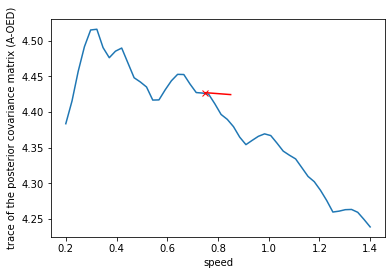

In [18]:
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2[control] = control_test
d_val, val = d_utilA_d_control(flying_parameters=flying_parameters_2)
val = np.trace(val)

fig, ax = plt.subplots(1,1)

ax.plot(vec_control, val_test_3)
ax.plot([control_test, control_test + 0.1], [val, val + 0.1 * d_val], color = "red")
ax.plot([control_test], [val], marker = "x", color = "red")

ax.set_xlabel(control)
ax.set_ylabel("trace of the posterior covariance matrix (A-OED)")

In [26]:
n_test

50

### derivative of the utility functions: D-OED

In [19]:
def d_utilD_d_control(flying_parameters=flying_parameters, bool_return_covar = True):
    der, postCov = d_PostCov_d_control(flying_parameters=flying_parameters, bool_return_both = True)
    
    if len(der) == 1:
        der = np.array([der])
        
    # apply transposed cofactor matrix 
    det = la.det(postCov)
    yolo = det * la.solve(postCov.T, der)
    # todo: the decomposition cofactor(M) = det(M)*inv(M) only holds for invertible matrices M
    # I don't think the posterior covariance matrix can become singular unless the prior or the noise covariance
    # matrices are degenerate. We might want to catch that case though.
        
    if bool_return_covar:
        return np.trace(yolo), postCov
    
    return np.trace(yolo)

In [20]:
val_test_4 = np.zeros((n_test,))
d_test_4 = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2[control] = vec_control[i]
    d_test_4[i], yolo = d_utilD_d_control(flying_parameters=flying_parameters_2)
    val_test_4[i] = la.det(yolo)

Text(0, 0.5, 'determinant of the posterior covariance matrix (D-OED)')

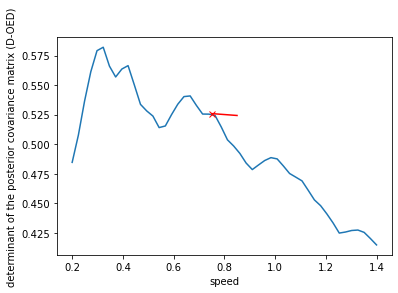

In [21]:
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2[control] = control_test
d_val, val = d_utilD_d_control(flying_parameters=flying_parameters_2)
val = la.det(val)

fig, ax = plt.subplots(1,1)

ax.plot(vec_control, val_test_4)
ax.plot([control_test, control_test + 0.1], [val, val + 0.1 * d_val], color = "red")
ax.plot([control_test], [val], marker = "x", color = "red")

ax.set_xlabel(control)
ax.set_ylabel("determinant of the posterior covariance matrix (D-OED)")

## Test

In [22]:
val_test_5 = np.zeros((n_test,2))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2[control] = vec_control[i]
    
    drone = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
    brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
    post = brain.compute_posterior()
    
    val_test_5[i, 0] = brain.eval_utility(post, oed_mode="A")
    val_test_5[i, 1] = brain.eval_utility(post, oed_mode="D")

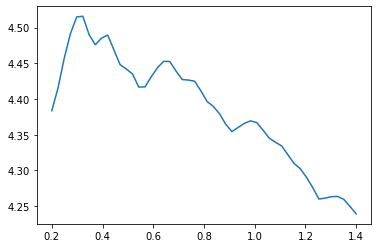

In [23]:
plt.plot(vec_control, val_test_5[:, 0])

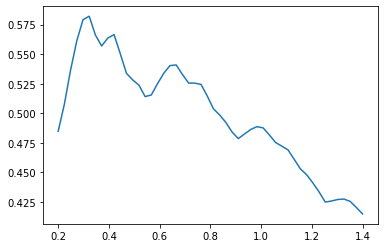

In [24]:
plt.plot(vec_control, val_test_5[:, 1])

In [25]:
# todo: should the noise correlation somehow account for revisiting the same position in the steady-state case?